# RNN From Scratch
Nationality prediction on the names dataset, using characters as tokens. There are 18 nationalities in the dataset.

Based off of:
https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

1) We download the data and process it.
2) We build an RNN from scratch
3) We train the RNN on test and demonstrate 70% accuracy after only a 50_000 samples.
4) We define a predict function and use it to create a confusion matrix on the whole dataset.

In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import zipfile

In [3]:
# download data from: https://download.pytorch.org/tutorial/data.zip
zipfile.ZipFile('data/names.zip').extractall('')
file_list = glob.glob('data/names/*.txt')
file_list

['data/names/Polish.txt',
 'data/names/Spanish.txt',
 'data/names/English.txt',
 'data/names/Irish.txt',
 'data/names/German.txt',
 'data/names/Chinese.txt',
 'data/names/Greek.txt',
 'data/names/Italian.txt',
 'data/names/Vietnamese.txt',
 'data/names/Czech.txt',
 'data/names/Korean.txt',
 'data/names/French.txt',
 'data/names/Dutch.txt',
 'data/names/Arabic.txt',
 'data/names/Scottish.txt',
 'data/names/Portuguese.txt',
 'data/names/Japanese.txt',
 'data/names/Russian.txt']

In [17]:
import unicodedata
import string
all_letters = string.ascii_lowercase + " .,;'"
print('letters to be encoded:', all_letters)
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    s=s.lower()
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

letters to be encoded: abcdefghijklmnopqrstuvwxyz .,;'
slusarski


In [18]:
data = pd.DataFrame(columns=['name', 'nationality'])
for f in file_list:
    temp = pd.read_csv(f, header = None, names=['name'], sep ='|')
    temp['nationality'] = f.split('/')[2][:-4] # file name with .txt removed
    data = pd.concat([data,temp], axis=0)
# convert names to ascii
data['name'] = data['name'].map(unicodeToAscii)
class_labels = data.nationality.unique()
data

,name,nationality
0,adamczak,Polish
1,adamczyk,Polish
2,andrysiak,Polish
3,auttenberg,Polish
4,bartosz,Polish
...,...,...
9403,zolotnitsky,Russian
9404,zolotnitzky,Russian
9405,zozrov,Russian
9406,zozulya,Russian


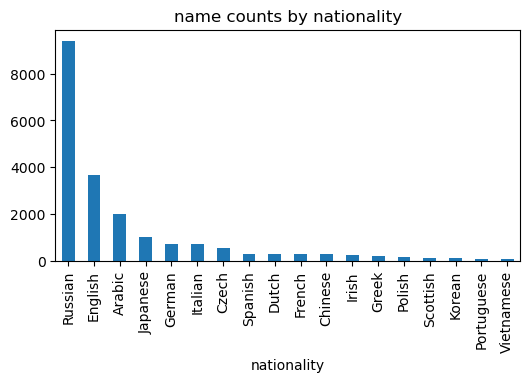

In [19]:
# plot value counts
data['nationality'].value_counts().plot(kind='bar', figsize=(6,3), title='name counts by nationality')
plt.show()

In [32]:
# lets find the characters appearing in the dataset to confirm they look reasonable
chars_in_data = set()
for n in data['name'].values:
    chars_in_data = chars_in_data.union(list(n))
chars_in_data = list(chars_in_data)
chars_in_data = sorted(chars_in_data)
print('characters appearing in the dataset:', ''.join(chars_in_data))

characters appearing in the dataset:  ',abcdefghijklmnopqrstuvwxyz


In [79]:
# functions to convert names to tensors
num_letters = len(all_letters)
def letter_to_ohe_tensor(letter):
    # function to convert a letter into one hot encoded vectors
    idx = torch.tensor(all_letters.find(letter))
    return F.one_hot(idx, num_letters).reshape(1,-1)

def name_to_ohe_tensor(name):
    # function to convert a name into one a tensort of ohe encoded vectors
    idxs = torch.tensor([all_letters.find(letter) for letter in name])
    return F.one_hot(idxs, num_letters)

name_to_ohe_tensor('alex,')

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 1, 0, 0]])

In [108]:
# lets build the RNN from scratch:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        # input to hidden
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        # hidden to output
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1) #concatenate
        hidden = self.i2h(combined) # concat feeds to hidden
        output = self.h2o(hidden) # hidden feeds to output
        output = self.softmax(output) # log probabilities (log softmax)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
n_categories = len(class_labels)
rnn = RNN(n_letters, n_hidden, n_categories)

# test on an input
hidden = rnn.initHidden()
ohe_letter = letter_to_ohe_tensor('a')
output, hidden = rnn(ohe_letter, hidden)
print(output.shape, hidden.shape)

torch.Size([1, 18]) torch.Size([1, 128])


In [109]:
# define a function to map a natioanlity to a tensor
nationality_to_idx = {n:idx for idx, n in enumerate(class_labels)}
def nationality_to_tensor(nationality):
    return torch.tensor(nationality_to_idx[nationality])

print(class_labels[0],':', nationality_to_tensor(class_labels[0]))
print(class_labels[1],':', nationality_to_tensor(class_labels[1]))

Polish : tensor(0)
Spanish : tensor(1)


In [110]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
criterion = nn.NLLLoss()

def train_name(name, nationality):
    X = name_to_ohe_tensor(name)
    y = nationality_to_tensor(nationality)

    hidden = rnn.initHidden()
    rnn.zero_grad()
    
    for x in X:
        output, hidden = rnn(x.reshape(1,-1), hidden)

    loss = criterion(output[0], y)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [111]:
# train model
rnn = RNN(n_letters, n_hidden, n_categories)

inputs, labels = data.name.values, data.nationality.values
iterations = 50_000
verbosity = int(iterations/10)

n_correct = 0
running_loss = 0
for i in range(iterations):
    idx = np.random.choice(len(inputs))
    input, label = inputs[idx], labels[idx]
    output, loss = train_name(input, label)
    _, pred_label = torch.max(output, 1)

    n_correct += (pred_label.item() == nationality_to_idx[label])
    running_loss += loss
    if (i+1) % verbosity == 0:
        accuracy = n_correct/verbosity
        running_loss = running_loss/verbosity
        print(f'iter {i}, loss {running_loss:.2f}, accuracy {accuracy:.2f}')
        n_correct, running_loss = 0, 0


iter 4999, loss 1.65, accuracy 0.51
iter 9999, loss 1.33, accuracy 0.61
iter 14999, loss 1.19, accuracy 0.66
iter 19999, loss 1.11, accuracy 0.67
iter 24999, loss 1.07, accuracy 0.68
iter 29999, loss 1.05, accuracy 0.69
iter 34999, loss 0.98, accuracy 0.71
iter 39999, loss 0.96, accuracy 0.71
iter 44999, loss 1.00, accuracy 0.70
iter 49999, loss 0.98, accuracy 0.71


In [126]:
# lets create a predict nationality function for a name
def predict_nationality(name, model):
    model.eval()
    X = name_to_ohe_tensor(name)
    hidden = rnn.initHidden()
    with torch.no_grad():
        for x in X:
            output, hidden = model(x.reshape(1,-1), hidden)
    log_prob, idx = torch.max(output, 1)
    return np.exp(log_prob.item()), class_labels[idx.item()]

prob, label = predict_nationality('george', rnn)
print(prob, label)

prob, label = predict_nationality('vladislav', rnn)
print(prob, label)

prob, label = predict_nationality('georgios', rnn)
print(prob, label)

0.5060706020719568 English
0.9984262952184977 Russian
0.413172379057131 Greek


In [132]:
# lets add a new column to the dataframe
data['prob_pred'] = [predict_nationality(name, model = rnn) for name in inputs]

In [133]:
data['prob'] = [x[0] for x in data['prob_pred']]
data['pred'] = [x[1] for x in data['prob_pred']]

Text(0.5, 1.0, 'Confusion Matrix')

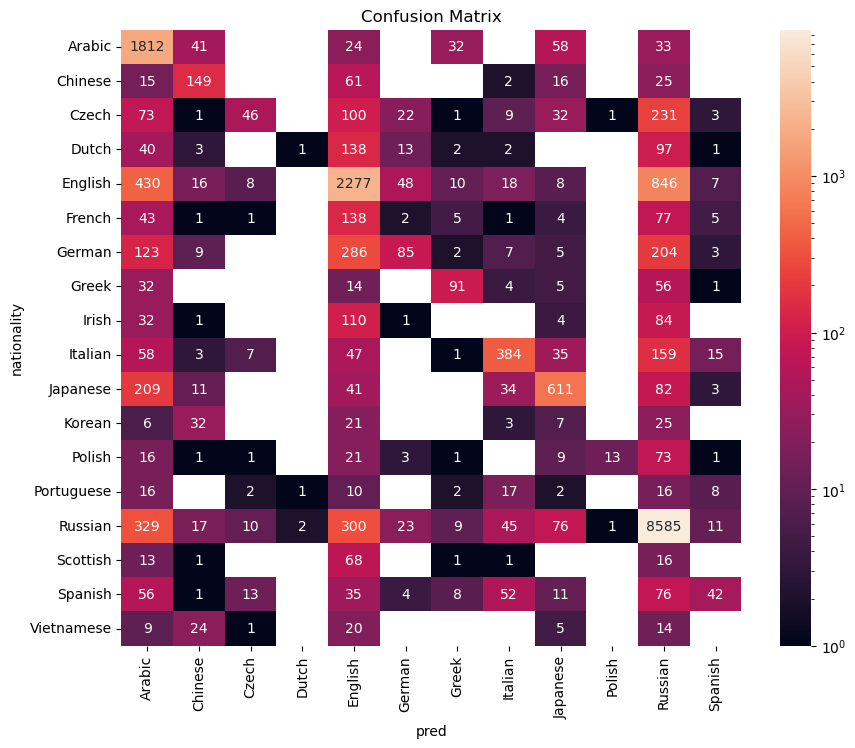

In [142]:
import seaborn as sns
from matplotlib.colors import LogNorm
plt.figure(figsize=(10,8))
sns.heatmap(pd.crosstab(data.nationality, data.pred).round(3), 
            annot = True, fmt='g', norm =LogNorm()).set_title('Confusion Matrix')